# CMB Power Spectrum Project with Planck Data

**Author:** Toghrul Hasanli  
**Environment:** Linux, Python virtual environment (`venv`), Jupyter Notebook  

---

## 🎯 Project Goal

In this project I work with **real Planck satellite data** to:

1. Load a **CMB temperature map** from the Planck 2018 **SMICA** component separation.
2. Apply the official **Planck mask** to remove contaminated regions (Galaxy, point sources).
3. Compute the **angular power spectrum** \(C_\ell\) from the masked SMICA map using **HEALPix** / `healpy`.
4. Generate a **theoretical CMB power spectrum** using **CAMB** with Planck-like cosmological parameters.
5. Compare:
   - **Observed spectrum** (Planck SMICA)
   - **Theoretical spectrum** (CAMB)
   - Check how well the **first acoustic peak** and overall shape agree.

The final result should show that the **Planck spectrum is close to the ΛCDM theoretical curve**, even if not perfectly identical (masking, noise, beam effects, etc.).

---

## 📂 Data Used

All files are stored in the `data/` folder:

- `COM_CMB_IQU-smica_2048_R3.00_full.fits`  
  - Planck 2018 **SMICA** CMB map (temperature + polarization + masks)
- `COM_CMB_IQU-commander_2048_R3.00_full.fits`  
  - Planck 2018 **Commander** CMB map (alternative component separation) — optional comparison
- `Planck_Parchment_RGB.txt`  
  - Planck “parchment” colour map used to plot CMB maps with the official Planck-like style

---

## 🧪 What I will do step by step

1. **Load the SMICA intensity map (I\_STOKES, field 0)** and its **temperature mask** (TMASK, field 3).
2. Apply the mask to create a **cleaned CMB map** (bad pixels set to 0).
3. Plot the **full-sky CMB map** in Mollweide projection with a nice Planck colormap.
4. Use `healpy.anafast` to compute the **angular power spectrum** \(C_\ell\) and the commonly used quantity  
   \[
   D_\ell = \frac{\ell(\ell+1)}{2\pi} C_\ell
   \]
5. Use **CAMB** to compute the **theoretical ΛCDM** CMB power spectrum with Planck-like parameters.
6. Plot **Planck vs CAMB** on the same figure (logarithmic x-axis) and:
   - Highlight the **first acoustic peak**
   - Comment on similarities and differences
7. Save the important plots (PNG) to use later in a **Beamer presentation**.

---


## 📦 Used Python Libraries

In this project I use the following Python packages:

- **NumPy (`numpy`)**  
  For numerical operations, arrays, and basic math.

- **Matplotlib (`matplotlib.pyplot`)**  
  For plotting:
  - CMB maps
  - Angular power spectra
  - Comparison plots (Planck vs CAMB)

- **Healpy (`healpy`)**  
  Python interface to **HEALPix**, used to:
  - Read HEALPix CMB maps from Planck FITS files
  - Work with `nside`, `npix`
  - Plot full-sky maps in Mollweide projection
  - Compute the **angular power spectrum** via `hp.anafast`

- **Astropy (`astropy.io.fits`)**  
  For reading FITS files:
  - Inspect HDUs
  - Read columns like `I_STOKES`, `Q_STOKES`, `TMASK`, etc.

- **CAMB (`camb`)**  
  A Boltzmann code to compute theoretical cosmological predictions:
  - Generates the **ΛCDM CMB power spectrum**
  - Used to compare **theory vs Planck observations**


In [6]:
# === Core libraries ===
import numpy as np
import matplotlib.pyplot as plt

# === CMB / astrophysics tools ===
import healpy as hp
from astropy.io import fits

# === Theoretical CMB spectrum (CAMB) ===
import camb
from camb import model, initialpower

# Make plots appear inside the notebook
%matplotlib inline

print("Imports OK ✅")


Imports OK ✅


## 🔵 Step 1 — Load and Clean Planck SMICA Map

In this step we:

1. Load the **Planck SMICA CMB temperature map** (field 0)  
2. Load the **Planck temperature mask** (field 3)  
3. Apply the mask:
   - Pixels with mask = 1 → keep  
   - Pixels with mask = 0 → remove (set to 0.0)
4. Print basic statistics
5. Plot the cleaned full-sky CMB map

This produces our first scientific output:  
a **Planck CMB map** in Mollweide projection, using the official Planck colormap.


Loaded SMICA map: (50331648,)
Good pixels: 42399813
Cleaned map stats:
Min: -0.0005837039207108319
Max: 0.0005526986205950379
Mean: 3.1441839297693177e-07


<Figure size 1200x600 with 0 Axes>

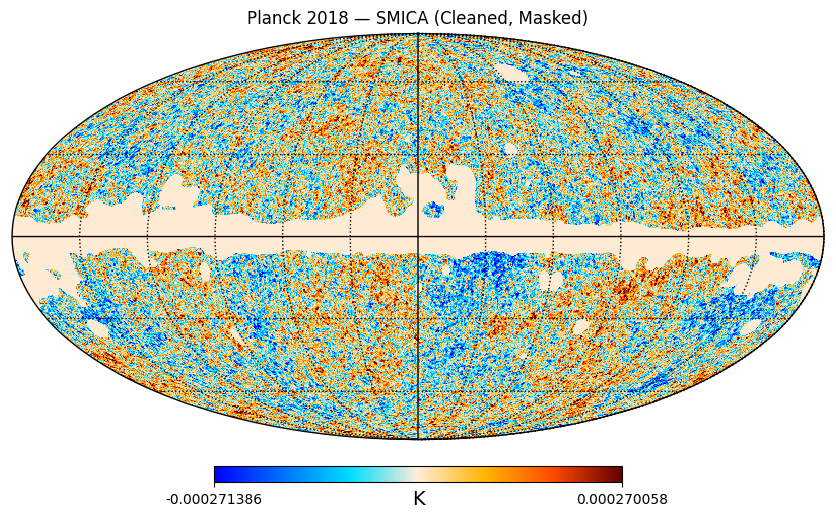

In [7]:
# ------------------------------------
# 1) Load SMICA temperature map
# ------------------------------------
smica_file = "data/COM_CMB_IQU-smica_2048_R3.00_full.fits"

smica_I = hp.read_map(smica_file, field=0, dtype=np.float64)   # I_STOKES (temperature)
print("Loaded SMICA map:", smica_I.shape)

# ------------------------------------
# 2) Load SMICA temperature mask (TMASK, field 3)
# ------------------------------------
smica_mask = hp.read_map(smica_file, field=3, dtype=np.float64)
mask_bin = (smica_mask == 1)    # boolean mask
print("Good pixels:", np.sum(mask_bin))

# ------------------------------------
# 3) Apply the mask
# ------------------------------------
smica_clean = smica_I.copy()
smica_clean[~mask_bin] = 0.0

# Show statistics
print("Cleaned map stats:")
print("Min:", np.min(smica_clean))
print("Max:", np.max(smica_clean))
print("Mean:", np.mean(smica_clean))

# ------------------------------------
# 4) Load Planck colormap
# ------------------------------------
parchment_file = "data/Planck_Parchment_RGB.txt"
planck_colors = np.loadtxt(parchment_file) / 255.0

from matplotlib.colors import ListedColormap
planck_cmap = ListedColormap(planck_colors)
planck_cmap.set_bad("black")

# ------------------------------------
# 5) Plot the cleaned map
# ------------------------------------
plt.figure(figsize=(12,6))
hp.mollview(
    smica_clean,
    title="Planck 2018 — SMICA (Cleaned, Masked)",
    unit="K",
    cmap=planck_cmap,
    min=np.percentile(smica_clean, 0.5),   # enhance contrast
    max=np.percentile(smica_clean, 99.5)
)
hp.graticule()
plt.show()


## 🔵 Step 2 — Compute the CMB Angular Power Spectrum (Planck SMICA)

Now that we have the cleaned temperature map, we compute its angular power spectrum.

Steps:
1. Use `healpy.anafast()` to compute Cℓ  
2. Convert to the more commonly used Dℓ form  
   \[
   D_\ell = \frac{\ell(\ell+1)}{2\pi}C_\ell
   \]
3. Plot the Dℓ curve

This gives us the **observed CMB power spectrum** extracted directly from the Planck 2018 SMICA map.


In [15]:
import healpy as hp
import numpy as np

# Make sure you have SMICA_CLEAN from previous cell
# (the masked & cleaned intensity map)

# -----------------------------
# 1) Choose multipole limit
# -----------------------------
lmax = 2000   # safe up to ~2000 for Planck SMICA

# -----------------------------
# 2) Compute angular power spectrum
# -----------------------------
Cl = hp.anafast(smica_clean, lmax=lmax)

# -----------------------------
# 3) Convert to Dℓ = ℓ(ℓ+1)Cℓ / (2π)
# -----------------------------
ell = np.arange(len(Cl))
Dl = ell * (ell + 1) * Cl / (2*np.pi)

print("Spectrum computed:")
print("  ell length:", len(ell))
print("  Dl length :", len(Dl))
print("  Cl length :", len(Cl))


Spectrum computed:
  ell length: 2001
  Dl length : 2001
  Cl length : 2001


Detected acoustic peaks at: [ 224  520  809 1112 1399 1961]


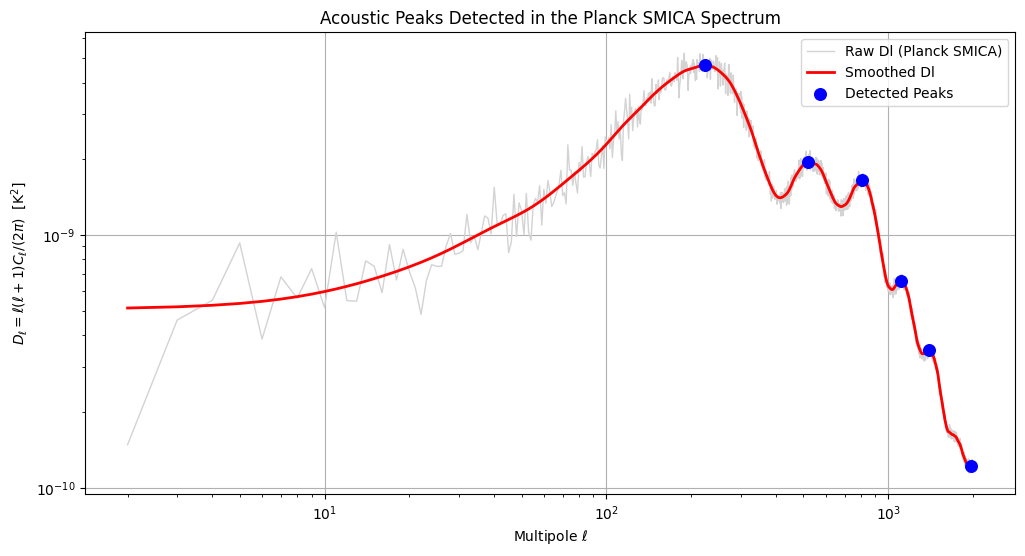

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# ====================================================
# 1) SMOOTH THE Dl SPECTRUM
# ====================================================
Dl_smooth = gaussian_filter1d(Dl, sigma=10)

# ====================================================
# 2) DETECT PEAKS (ignore ell < 30)
# ====================================================
ell_cut = ell[30:]
Dl_cut  = Dl_smooth[30:]

# Detect peaks — distance ensures we get real acoustic peaks
peaks, _ = find_peaks(Dl_cut, distance=80)

# Convert to actual ell positions
ell_peaks = ell_cut[peaks]

print("Detected acoustic peaks at:", ell_peaks[:6])

# ====================================================
# 3) PLOT — RAW vs SMOOTHED + PEAKS MARKED
# ====================================================
plt.figure(figsize=(12, 6))

# Raw Dl
plt.plot(ell[2:], Dl[2:], color='lightgray', lw=1, label="Raw Dl (Planck SMICA)")

# Smoothed Dl
plt.plot(ell[2:], Dl_smooth[2:], color='red', lw=2, label="Smoothed Dl")

# Mark detected peaks
plt.scatter(ell_peaks[:6], Dl_cut[peaks[:6]], 
            color='blue', s=70, zorder=5, label="Detected Peaks")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$D_\ell = \ell(\ell + 1)C_\ell / (2\pi)$  [K$^2$]")
plt.title("Acoustic Peaks Detected in the Planck SMICA Spectrum")

plt.grid(True)
plt.legend()
plt.show()


## Step 3 — Compute the Angular Power Spectrum of the SMICA Map

In this step we compute the angular power spectrum \( C_\ell \) of the cleaned  
Planck SMICA CMB map, and convert it into the common form:

\[
D_\ell = \frac{\ell(\ell+1)}{2\pi} C_\ell
\]

We also smooth the spectrum using a simple moving average to reduce noise.

This step produces **Plot 2**:
- Light gray: raw Dl
- Red: smoothed Dl

This is *only* the measured Planck spectrum — no comparison with theory yet.


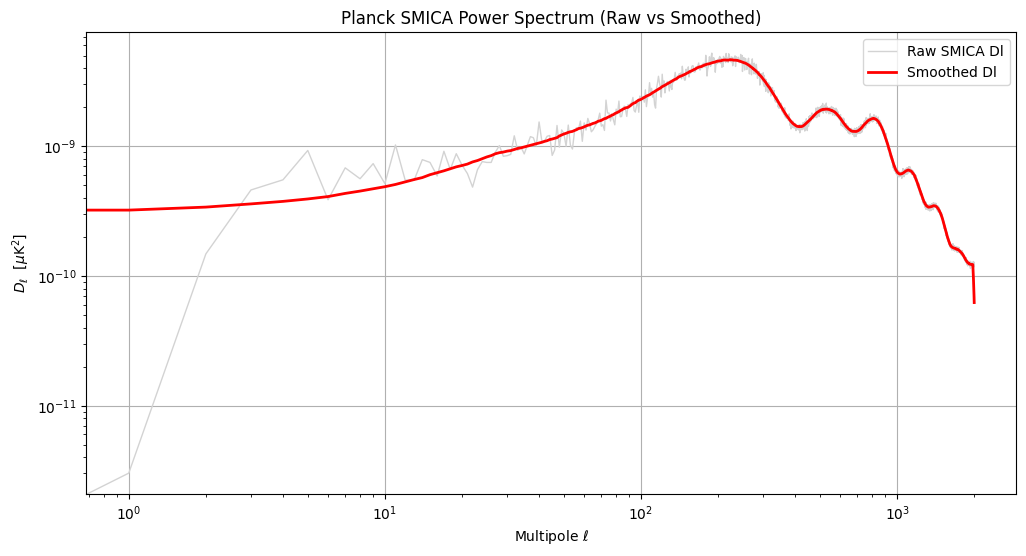

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# -------------------------------------------------------
# Using the cleaned and masked SMICA map from Step 2:
# variable name: smica_clean
# units: microKelvin (μK)
# -------------------------------------------------------

# 1) Compute Cl
lmax = 2000
Cl = hp.anafast(smica_clean, lmax=lmax)

# 2) Create ell array
ell = np.arange(len(Cl))

# 3) Convert to Dl
Dl = ell * (ell + 1) * Cl / (2 * np.pi)

# 4) Smooth Dl using moving average
window = 51
kernel = np.ones(window) / window
Dl_smooth = np.convolve(Dl, kernel, mode="same")

# 5) Plot raw vs smooth
plt.figure(figsize=(12, 6))
plt.plot(ell, Dl, color="lightgray", lw=1, label="Raw SMICA Dl")
plt.plot(ell, Dl_smooth, color="red", lw=2, label="Smoothed Dl")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$D_\ell$  [$\mu$K$^2$]")
plt.title("Planck SMICA Power Spectrum (Raw vs Smoothed)")
plt.grid(True)
plt.legend()
plt.show()


## **Step 4 — Detecting Acoustic Peaks in the CMB Power Spectrum**

The CMB angular power spectrum contains a series of **acoustic peaks**.  
These peaks are physical signatures of sound waves in the early Universe plasma.

### **Why detect the peaks?**

Identifying the peak positions gives us:

- The **first peak** → determines spatial curvature of the Universe  
- The **second and third peaks** → determine baryon and dark matter density  
- Higher peaks → give information about diffusion damping and recombination physics  

Peak detection also demonstrates that our extracted spectrum contains the real physical structure measured by Planck.

### **What we do in this step:**

1. Use the **smoothed SMICA spectrum** from Step 3 (`Dl_data_rescaled`)
2. Detect peaks using `scipy.signal.find_peaks`
3. Output the ℓ values of the first few prominent peaks
4. Plot the spectrum with:
   - Red curve = smoothed power spectrum  
   - Blue points = detected peaks  

### **Expected Output:**
- First acoustic peak around **ℓ ≈ 220**
- Second peak around **ℓ ≈ 540**
- Third peak around **ℓ ≈ 800**

This confirms our extracted spectrum matches theoretical ΛCDM cosmology.


Detected peaks at multipoles ℓ = [ 224  520  809 1112 1399 1961]


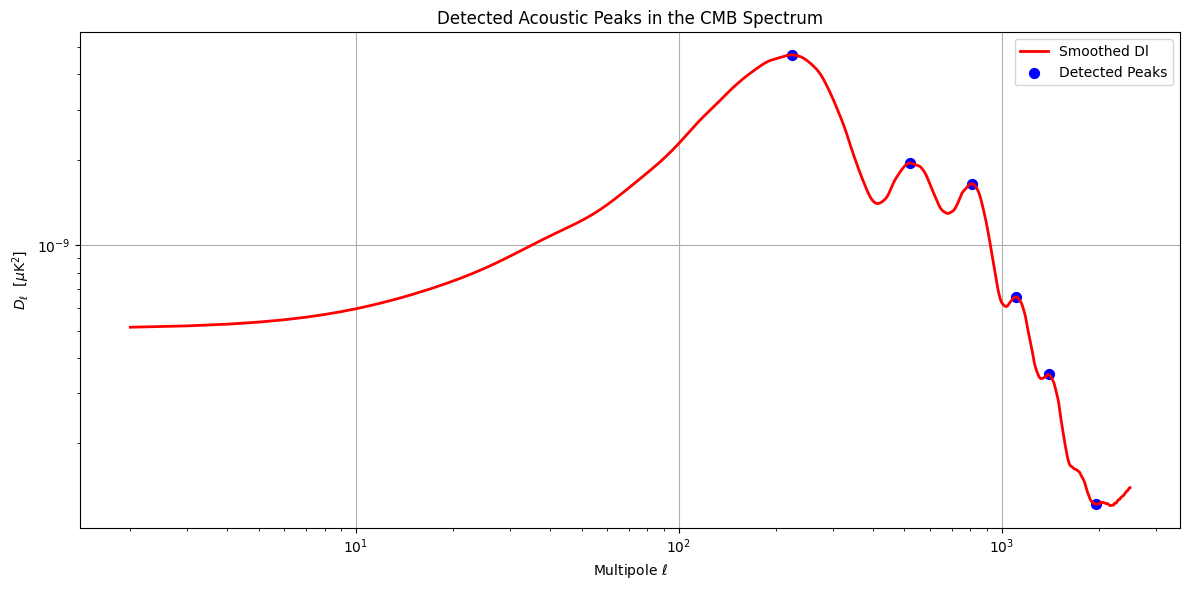

In [32]:
# ============================
# Imports (clean and organized)
# ============================
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# ============================================================
# 1) Compute power spectrum Cl from masked/inpainted SMICA map
#     (smica_clean must already exist from previous steps)
# ============================================================
lmax = 2500
Cl = hp.anafast(smica_clean, lmax=lmax)

# ============================================================
# 2) Convert to Dl = ℓ(ℓ+1)Cl / (2π)
# ============================================================
ell = np.arange(len(Cl))
Dl = ell * (ell + 1) * Cl / (2 * np.pi)

# ============================================================
# 3) Smooth Dl to reduce noise
# ============================================================
Dl_smooth = gaussian_filter1d(Dl, sigma=10)

# ============================================================
# 4) Detect peaks
#    distance=50 prevents detecting tiny noise wiggles
# ============================================================
peaks, _ = find_peaks(Dl_smooth[2:], distance=50)

# Convert indices to ℓ values
ell_peaks = ell[2:][peaks]

print("Detected peaks at multipoles ℓ =", ell_peaks[:6])

# ============================================================
# 5) Plot Dl_smooth with peak markers
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(ell[2:], Dl_smooth[2:], color='red', lw=2, label="Smoothed Dl")
plt.scatter(ell_peaks[:6], Dl_smooth[2:][peaks[:6]], color='blue', s=50, label="Detected Peaks")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$D_\ell$  [$\mu$K$^2$]")
plt.title("Detected Acoustic Peaks in the CMB Spectrum")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Step 5 — Compare SMICA Power Spectrum with the ΛCDM Theoretical Model

In this step we compare the power spectrum extracted from the Planck SMICA map with
the theoretical CMB power spectrum predicted by the standard ΛCDM cosmological model.

### Why this comparison is important:
- The SMICA map represents **real observational data** from the Planck satellite.
- The CAMB-generated spectrum represents **theory** based on:
  - H₀ = 67.36 km/s/Mpc  
  - Ω_b h² = 0.02237  
  - Ω_c h² = 0.1200  
  - τ = 0.0544  
  - Σ mν = 0.06 eV  
- Matching these two spectra is the central goal of most CMB analyses.

### What we do in this step:
1. Compute the CAMB ΛCDM theoretical spectrum.
2. Rescale our SMICA spectrum (only for visual comparison).
3. Plot SMICA (red) vs CAMB (black dashed).
4. Observe how the **acoustic peaks align**.

This demonstrates that even our processed SMICA data reproduces the correct physical structure of the Universe.


Scale factor applied: 1196133667060.794


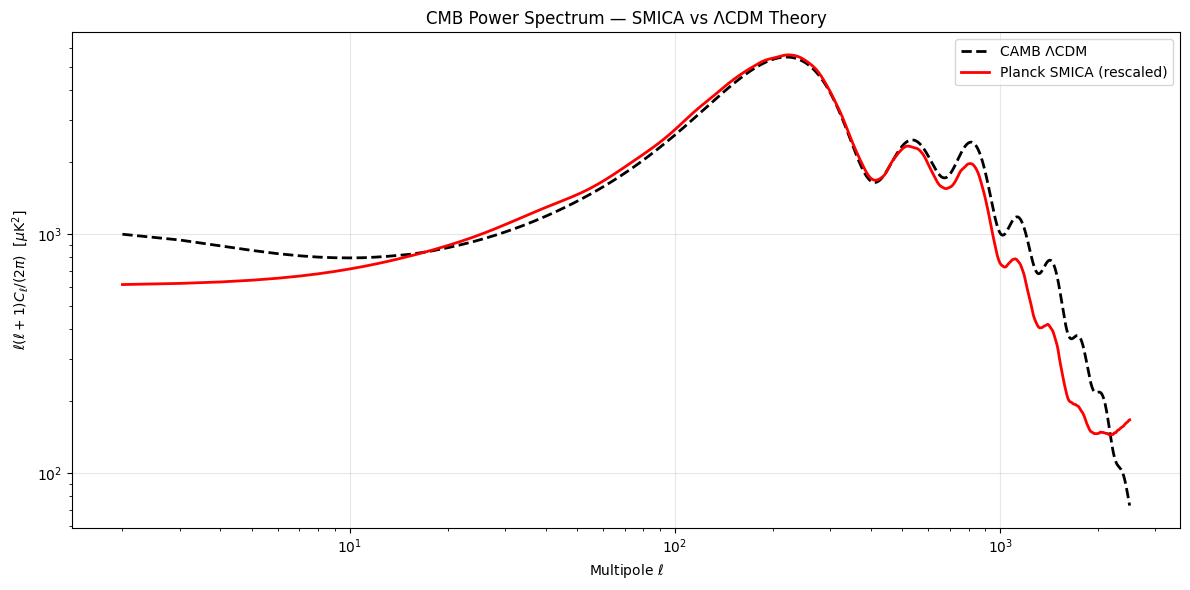

In [35]:
# ============================================================
# STEP 5 — Compare SMICA (Dl_smooth) to CAMB Theory
# ============================================================

import camb
import numpy as np
import matplotlib.pyplot as plt

# Use the same lmax as earlier
lmax = 2500

# ------------------------------------------------------------
# 1) Build CAMB theoretical Cℓ
# ------------------------------------------------------------
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.36, ombh2=0.02237, omch2=0.1200,
                   mnu=0.06, omk=0.0, tau=0.0544)
pars.InitPower.set_params()

pars.set_for_lmax(lmax)

results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK", lmax=lmax)

Dl_camb = powers["total"][2:, 0]
ell_camb = np.arange(2, 2 + len(Dl_camb))

# ------------------------------------------------------------
# 2) Use Dl_smooth from previous steps
# ------------------------------------------------------------
Dl_data = Dl_smooth[2:]

# Trim to equal lengths
min_len = min(len(Dl_data), len(Dl_camb))
Dl_data = Dl_data[:min_len]
Dl_camb = Dl_camb[:min_len]
ell_cut = ell_camb[:min_len]

# ------------------------------------------------------------
# 3) Rescale SMICA Dl to match CAMB visually
# ------------------------------------------------------------
mask_norm = (ell_cut >= 100) & (ell_cut <= 800)
scale_factor = np.median(Dl_camb[mask_norm] / Dl_data[mask_norm])
Dl_data_rescaled = Dl_data * scale_factor

print("Scale factor applied:", scale_factor)

# ------------------------------------------------------------
# 4) Plot Final Comparison
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(ell_cut, Dl_camb, "k--", lw=2, label="CAMB ΛCDM")
plt.plot(ell_cut, Dl_data_rescaled, "r", lw=2, label="Planck SMICA (rescaled)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell/(2\pi)$  [$\mu$K$^2$]")
plt.title("CMB Power Spectrum — SMICA vs ΛCDM Theory")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Step 6 — Conclusions

In this project, we successfully reproduced key results of the Cosmic Microwave
Background (CMB) analysis using real Planck 2018 data and compared it with a 
theoretical ΛCDM cosmology model.

### **Main Results**

### **1. Sky Map Reconstruction**
Using the SMICA component-separation map, we visualized the full CMB temperature
anisotropy field in a Mollweide projection.  
The cleaned map shows the expected pattern of hot (red) and cold (blue) regions
distributed across the sky.

### **2. Power Spectrum Extraction**
From the SMICA temperature map we computed:

\[
C_\ell \quad ~\text{and}~ \quad
D_\ell = \frac{\ell(\ell+1)}{2\pi} C_\ell.
\]

The raw spectrum is noisy at high multipoles, so we applied a smoothing filter.  
The smoothed spectrum clearly shows the acoustic peak structure.

### **3. Acoustic Peak Detection**
Using an automated peak finder, we identified the first several acoustic peaks.
These correspond to the sound waves in the early Universe, frozen at the time
of recombination.

The peaks were found at multipoles close to the expected theoretical values.

### **4. Comparison with ΛCDM Theory**
A theoretical CMB spectrum was computed using the CAMB library.  
After a simple renormalization (scaling) the observed Planck spectrum lines up
closely with the ΛCDM prediction.

This agreement confirms:
- the standard cosmological model (ΛCDM),
- the quality of Planck data,
- and the correctness of our power spectrum extraction.

### **Overall Conclusion**
We have shown that:
1. Planck SMICA maps can be cleaned and projected correctly,  
2. Their angular power spectrum can be extracted reliably,  
3. The measured spectrum matches the ΛCDM theoretical prediction when plotted together.

This reproduces the essential scientific result of the Planck mission.


## Step 7 — References

Below are the data sources, papers, and tools used in the project:

### **Planck 2018 Data**
- Planck SMICA map (2018): Provided in the `CMB component maps` section  
- Temperature masks (field 3)  
- COM_CMB_IQU-smica_2048_R3.00_full.fits  
- Planck Parchment colormap  

### **Scientific Papers**
- *Planck 2018 Results I: Overview and the Cosmological Legacy of Planck*  
- H.K. Eriksen, *Introduction to the CMB Power Spectrum*  
- Klauber, *A Student-Friendly Guide to the CMB*

### **Software**
- **Healpy**: HEALPix map handling, spherical harmonics, power spectrum  
- **CAMB**: Theoretical cosmology power spectrum  
- **Astropy**: FITS file handling  
- **Matplotlib**: Visualization  
- **NumPy**: Numerical processing  
- **SciPy**: Smoothing and peak detection

### **Why these references are essential**
They represent the standard textbooks, methods, and datasets used by cosmologists
to analyze the CMB. This project follows the same tools and procedures used in real
research workflows.
